In [1]:
# Import the modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scin
import scipy.interpolate as scinter
import Units as u

ModuleNotFoundError: No module named 'Units'

In [3]:
# Rewrites the print statements
cursor_up = '\x1b[2K\r'

# Read the EOS for NS
data = np.loadtxt('BCPM.dat').T
f = scinter.interp1d(data[0], data[1])
g = scinter.interp1d(data[0], data[2])
df = scinter.interp1d(data[0], data[3])

In [4]:
# Define the maximal and minimal pressures
pmax = 0.9*max(data[0]) # [MeV/fm**3]
pmin = 1.1*min(data[0]) # [MeV/fm**3]
pmx = pmax*u.MeV_fm3_2_Msun_km3 # [Msun/km**3]
pmn = pmin*u.MeV_fm3_2_Msun_km3 # [Msun/km**3]

# Mass of the boson
mu = 1e-16 # [MeV]
mu2 = mu**2/u.hbarc_MeVfm**2 # [1/fm**2]

# Interaction coupling constants
iLambda = 0.0
iKappa = 0.0
iF = 0.0
Lambda = iLambda*mu2*u.G_fm_MeV # [1/(MeV*fm)]
#Kappa = iKappa*mu2*(u.G_fm_MeV)**2 # [1/MeV**2]
Kappa = iKappa*Lambda**2/mu2 # [1/MeV**2]
F = iF/u.G_fm_MeV # [MeV/fm]

# Threshold field
phi_tol = 1e-10

# Scales
scaleR = u.hbarc_MeVfm/mu*u.fm_2_km # [km]
scalep = pmx/5.0 # [Msun/km**3]
scalephi = 1.0/np.sqrt(8*np.pi*u.G_km_Msun) # [sqrt(Msun/km)]
scaleomega = 1.0/scaleR # [1/km]

# Pressure, central field and field frequency values
ip = 1.5
iphi = 0.0
iomega = 2**(abs(iLambda/50) + abs(iKappa/10))*12**iphi # Estimation of the bosons internal frequency


In [5]:
# Creat the space grid
R0 = 0.0
if iphi == 0:
    Rf = 30
else:
    Rf = 12*scaleR/np.sqrt(iphi)
step = 1e-3
r = np.arange(R0, Rf, step)
N = len(r)

# Initial conditions
a0 = 0.0 # Arbitrary
b0 = 0.0

# Pressure [Msun/km**3]
p0 = ip*scalep

# Field [sqrt(Msun/km)]
phi0 = iphi*scalephi
dphi0 = 0.0

# Omega [1/km]
omega_max = iomega*scaleomega
omega_min = 0.0

# Number of iterations for the shooting
iterations = 50

# Number of iterations to find a non-oscillating solution for the BS
Ntrials = 40

In [6]:
# Potential of the Boson star
def Vpot(phi):
    phis = phi/np.sqrt(u.MeV_fm_2_Msun_km)
    if iF == 0:
        V = mu2*phis**2 + Lambda*phis**4 + Kappa*phis**6
    else:
        V = mu2*phis**2 + Lambda*phis**4 + Kappa*phis**6 + F/mu2*np.log(1.0 + phi**2/F)
    return V*u.MeV_fm3_2_Msun_km3

def dVpot(phi):
    phis = phi/np.sqrt(u.MeV_fm_2_Msun_km)
    if iF == 0:
        dV = mu2 + 2.0*Lambda*phis**2 + 3.0*Kappa*phis**4
    else:
        dV = mu2 + 2.0*Lambda*phis**2 + 3.0*Kappa*phis**4 + 1.0/(mu2*(1.0 + phi**2/F))
    return dV/u.fm_2_km**2


In [7]:
# Equation of state of the Neutron star
def EoS(p):
    ps = p/u.MeV_fm3_2_Msun_km3
    rho = f(ps)
    n = g(ps)
    drho_dp = df(ps)
    return np.array([rho*u.MeV_fm3_2_Msun_km3, n/u.fm_2_km**3, drho_dp])


# TOV Equations
def TOV_BS(r, var, omega):
    a, b, phi, dphi = var
    
    if r == 0.0:
        du1 = 0.0
    else:
        du1 = 1.0/r
    
    A = np.exp(a)
    B = np.exp(b)
    
    # Equations
    da = 8*np.pi*u.G_km_Msun*r*B*(omega**2*phi**2/A - Vpot(phi) + dphi**2/B) + (B-1.0)*du1
     
    db = 8*np.pi*u.G_km_Msun*r*B*(omega**2*phi**2/A + Vpot(phi) + dphi**2/B) - (B-1.0)*du1
    
    if r != 0.0:
        ddphi = phi*B*(dVpot(phi) - omega**2/A) + dphi*du1*(8*np.pi*u.G_km_Msun*B*r**2*Vpot(phi) - (1.0+B))
    else:
        ddphi = phi/3.0*(dVpot(phi) - omega**2/A)
        
    return np.array([da, db, dphi, ddphi])


def TOV_NS(r, var):
    a, b, p = var
    
    if p <= pmn:
        p = 0
        rho = 0
        n = 0
    else:
        rho, n, drho_dp = EoS(p)
    
    if r == 0.0:
        du1 = 0.0
    else:
        du1 = 1.0/r
    
    A = np.exp(a)
    B = np.exp(b)

    # Equations
    da = 8*np.pi*u.G_km_Msun*r*B*p + (B-1.0)*du1
        
    db = 8*np.pi*u.G_km_Msun*r*B*rho - (B-1.0)*du1
    
    dp = -(rho + p)*da/2.0
    
    return np.array([da, db, dp])


def TOV_BNS(r, var, omega):
    a, b, p, phi, dphi = var
    
    if p <= pmn:
        p = 0
        rho = 0
        n = 0
    else:
        rho, n, drho_dp = EoS(p)
    
    if r == 0.0:
        du1 = 0.0
    else:
        du1 = 1.0/r

    A = np.exp(a)
    B = np.exp(b)

    # Equations    
    da = 8*np.pi*u.G_km_Msun*r*B*(omega**2*phi**2/A + p - Vpot(phi) + dphi**2/B) + (B-1.0)*du1
        
    db = 8*np.pi*u.G_km_Msun*r*B*(omega**2*phi**2/A + rho + Vpot(phi) + dphi**2/B) - (B-1.0)*du1
    
    dp = -(rho + p)*da/2.0
    
    if r != 0.0:
        ddphi = phi*B*(dVpot(phi) - omega**2/A) + dphi*du1*(4*np.pi*u.G_km_Msun*B*r**2*(rho - p + 2.0*Vpot(phi)) - (1.0+B))
    else:
        ddphi = phi/3.0*(dVpot(phi) - omega**2/A)
        
    return np.array([da, db, dp, dphi, ddphi])


In [8]:
# Solve the Boson star
def BS(phi0):
    iphi_dyn = phi0/scalephi
    Rf = 12*scaleR/np.sqrt(iphi_dyn)
    r = np.arange(R0, Rf, step)
    N = len(r)
    iomega_dyn = 2**(abs(iLambda/50) + abs(iKappa/10))*14**iphi_dyn

    # Set the initial conditions
    vinic = [a0, b0, phi0, dphi0]
    for trials in range(Ntrials):
        #print('trial/Ntrials = ', str(trials+1)+'/'+str(Ntrials))
        omega_max = iomega_dyn*scaleomega
        omega_min = 0.0
        for it in range(iterations):
            #print('iteration = ', it)
            omega = (omega_max + omega_min)/2.0
            #print('omega = ', omega)
            
            sol_BS = scin.solve_ivp(TOV_BS, (R0, Rf), vinic, method = 'RK45',
                                    t_eval = r, rtol = 1e-13, atol = 1e-13,
                                    args = (omega,))
            
            a, b, phi, dphi = sol_BS.y

            #print('phi_end = ', phi[-1])
            if abs(phi[-1]) < phi_tol:
                #print('Finished at i = ', it)
                break
        
            if phi[-1] > 0:
                omega_min = omega
            else:
                omega_max = omega
            #print('----------------------------------')

        # Check oscillating solution
        ddphi = np.zeros(N)
        for i in range(N):
            da_val, db_val, dphi_val, ddphi_val = TOV_BS(r[i], [a[i], b[i], phi[i], dphi[i]], omega)
            ddphi[i] = ddphi_val

        zeros = np.where(np.diff(np.sign(ddphi)) != 0)
        Nzeros = len(zeros[0])
        if Nzeros == 1:
            print('BS achieved')
            break
        else:
            iomega_dyn /= 1.1
    
    
    # Extract the observables
    A = np.exp(a)
    B = np.exp(b)
    omega /= np.sqrt(A[-1]*B[-1]) # Rescale omega
    A_inf = 1/B[-1]
    A *= A_inf/A[-1] # Rescale the gtt component
    correct_a0 = np.log(A[0])
    M_BS = r/(2*u.G_km_Msun)*(1.0 - 1.0/B)
    M_BS[0] = 0

    idx = np.where(M_BS >= 0.99*max(M_BS))[0][0]
    Radius_BS = r[idx]
    Mass_BS = M_BS[idx]
    Bosons_BS = scin.simpson(8*np.pi/u.hbarc_Msunkm*r[:idx]**2*np.sqrt(B[:idx]/A[:idx])*omega*phi[:idx]**2/u.Nsun, x = r[:idx])
    return [np.array([r, A, B, M_BS, phi]), np.array([Radius_BS, Mass_BS, Bosons_BS, omega, correct_a0])]



In [9]:
# Solve the Neutron star
def NS(p0):
    Rf = 30.0
    r = np.arange(R0, Rf, step)
    N = len(r)
    
    vinic = [a0, b0, p0]
    sol_NS = scin.solve_ivp(TOV_NS, (R0, Rf), vinic, method = 'RK45',
                            t_eval = r, rtol = 1e-13, atol = 1e-13)
    
    a, b, p = sol_NS.y
    A = np.exp(a)
    B = np.exp(b)
    A_inf = 1/B[-1]
    A *= A_inf/A[-1] # Rescale the gtt component
    correct_a0 = np.log(A[0])
    M_NS = r/(2*u.G_km_Msun)*(1.0 - 1.0/B)
    M_NS[0] = 0
    
    idx = np.where(p <= pmn)[0][0]
    rho, n, drho_dp = EoS(p[:idx])
    Radius_NS = r[idx]
    Mass_NS = M_NS[idx]
    Baryons_NS = scin.simpson(4*np.pi*r[:idx]**2*np.sqrt(B[:idx])*n/u.Nsun, x = r[:idx])
    return [np.array([r, A, B, M_NS, p]), np.array([Radius_NS, Mass_NS, Baryons_NS, correct_a0])]


In [10]:
# Solve the Boson-Neutron star
def BNS(p0, phi0):
    iphi_dyn = phi0/scalephi
    ip_dyn = p0/scalep
    if iphi_dyn == 0:
        Rf = 30.0
        iomega_dyn = 0.0
    elif ip_dyn <= 0.1:
        Rf = 12*scaleR/np.sqrt(iphi_dyn)
        iomega_dyn = 2**(abs(iLambda/50) + abs(iKappa/10))*12**iphi_dyn
    else:
        Rf = 11*scaleR*iphi_dyn**(1/3)/np.sqrt(iphi_dyn)
        iomega_dyn = 2**(abs(iLambda/50) + abs(iKappa/10))*(14*(np.floor(ip_dyn) + 1)**(abs(np.log(iphi_dyn))))**iphi_dyn
    r = np.arange(R0, Rf, step)
    N = len(r)
    
    vinic = [a0, b0, p0, phi0, dphi0]
    for trials in range(Ntrials):
        #print('trial/Ntrials = ', str(trials+1)+'/'+str(Ntrials))
        omega_max = iomega_dyn*scaleomega
        omega_min = 0.0
    
        for it in range(iterations):
            #print('iteration = ', it)
            omega = (omega_max + omega_min)/2.0
            #print('omega = ', omega)
            
            sol_BNS = scin.solve_ivp(TOV_BNS, (R0, Rf), vinic, method = 'RK45',
                                    t_eval = r, rtol = 1e-13, atol = 1e-13,
                                    args = (omega,))
            
            a, b, p, phi, dphi = sol_BNS.y
            
            #print('phi_end = ', phi[-1])
            if abs(phi[-1]) < phi_tol:
                #print('Finished at i = ', it)
                break
        
            if phi[-1] > 0:
                omega_min = omega
            else:
                omega_max = omega
            
            #print('----------------------------------')
            
        # Check oscillating solutions
        ddphi = np.zeros(N)
        for i in range(N):
            da_val, db_val, dp_val, dphi_val, ddphi_val = TOV_BNS(r[i], [a[i], b[i], p[i], phi[i], dphi[i]], omega)
            ddphi[i] = ddphi_val
        
        zeros = np.where(np.diff(np.sign(ddphi)) != 0)
        Nzeros = len(zeros[0])
        if Nzeros <= 1:
            print('BNS achieved')
            break
        else:
            iomega_dyn /= 1.05
    
    # Extract the observables
    A = np.exp(a)
    B = np.exp(b)
    omega /= np.sqrt(A[-1]*B[-1]) # Rescale omega
    A_inf = 1/B[-1]
    A *= A_inf/A[-1] # Rescale the gtt component
    correct_a0 = np.log(A[0])
    M_BNS = r/(2*u.G_km_Msun)*(1.0 - 1.0/B)
    M_BNS[0] = 0

    idx = np.where(M_BNS >= 0.99*max(M_BNS))[0][0]
    Radius_BNS = r[idx]
    Mass_BNS = M_BNS[idx]
    if iphi_dyn != 0:
        Bosons_BNS = scin.simpson(8*np.pi/u.hbarc_Msunkm*r[:idx]**2*np.sqrt(B[:idx]/A[:idx])*omega*phi[:idx]**2/u.Nsun, x = r[:idx])
    else:
        Bosons_BNS = 0

    idx = np.where(p <= pmn)[0][0]
    rho, n, drho_dp = EoS(p[:idx])
    Radius_NBS = r[idx]
    Mass_NBS = M_BNS[idx]
    if ip_dyn != 0:
        Baryons_NBS = scin.simpson(4*np.pi*r[:idx]**2*np.sqrt(B[:idx])*n/u.Nsun, x = r[:idx])
    else:
        Baryons_NBS = 0
    return [np.array([r, A, B, M_BNS, p, phi]), np.array([Radius_NBS, Mass_NBS, Baryons_NBS, Radius_BNS, Mass_BNS, Bosons_BNS, omega, correct_a0])]


In [11]:
# Solve one of each
try:
    sols_BS = BS(phi0)
    print(sols_BS[1])
except:
    print('Not achieved BS')


sols_NS = NS(p0)
print(sols_NS[1])

try:
    sols_BNS = BNS(p0, phi0)
    print(sols_BNS[1])
except:
    print('Not achieved BNS')




# Solve many BS
phi0 = scalephi*np.exp(np.linspace(np.log(0.1), np.log(2.0), 50))
N_BS = len(phi0)

R_BS = np.zeros(N_BS)
M_BS = np.zeros(N_BS)
B_BS = np.zeros(N_BS)
omega_BS = np.zeros(N_BS)
a0_BS = np.zeros(N_BS)
for i in range(N_BS):
    print('i/N = ', str(i+1)+'/'+str(N_BS))
    try:
        sol = BS(phi0[i])
        R_BS[i] = sol[1][0]
        M_BS[i] = sol[1][1]
        B_BS[i] = sol[1][2]
        omega_BS[i] = sol[1][3]
        a0_BS[i] = sol[1][4]
    except:
        print('Not achieved BS')
        continue
        
# Save the data
np.savetxt('BS.dat', np.array([R_BS, M_BS, B_BS, phi0, omega_BS, a0_BS]).T)


/tmp/ipykernel_32027/2732607503.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  Rf = 12*scaleR/np.sqrt(iphi_dyn)


Not achieved BS
[10.655       1.96640156  2.61437584 -1.91756459]
BNS achieved
[10.654       1.96640156  2.61437584 10.121       1.94676295  0.
  0.         -1.91756459]
i/N =  1/50
BS achieved
i/N =  2/50
BS achieved
i/N =  3/50
BS achieved
i/N =  4/50
BS achieved
i/N =  5/50
BS achieved
i/N =  6/50
BS achieved
i/N =  7/50
BS achieved
i/N =  8/50
BS achieved
i/N =  9/50
BS achieved
i/N =  10/50
BS achieved
i/N =  11/50
BS achieved
i/N =  12/50
BS achieved
i/N =  13/50
BS achieved
i/N =  14/50
BS achieved
i/N =  15/50
BS achieved
i/N =  16/50
BS achieved
i/N =  17/50
BS achieved
i/N =  18/50
BS achieved
i/N =  19/50
BS achieved
i/N =  20/50
BS achieved
i/N =  21/50
BS achieved
i/N =  22/50
BS achieved
i/N =  23/50
BS achieved
i/N =  24/50
BS achieved
i/N =  25/50
BS achieved
i/N =  26/50
BS achieved
i/N =  27/50
BS achieved
i/N =  28/50
BS achieved
i/N =  29/50
BS achieved
i/N =  30/50
BS achieved
i/N =  31/50
BS achieved
i/N =  32/50
BS achieved
i/N =  33/50
BS achieved
i/N =  34/50
B

"\n\n# Solve many BNS\nphi0 = scalephi*np.exp(np.linspace(np.log(0.1), np.log(2.0), 50))\np0 = scalep*np.exp(np.linspace(np.log(8e-3), np.log(5.0), 50))\nphi0 = np.insert(phi0, 0, 0)\np0 = np.insert(p0, 0, 0)\n\nN_NS = len(p0)\nN_BS = len(phi0)\n\np0_BNS = np.reshape(np.kron(p0, np.ones(N_BS)), (N_NS, N_BS))\nphi0_BNS = np.reshape(np.kron(phi0, np.ones(N_NS)), (N_BS, N_NS)).T\n\nR_NBS = np.zeros((N_NS, N_BS))\nM_NBS = np.zeros((N_NS, N_BS))\nB_NBS = np.zeros((N_NS, N_BS))\nR_BNS = np.zeros((N_NS, N_BS))\nB_BNS = np.zeros((N_NS, N_BS))\nM_BNS = np.zeros((N_NS, N_BS))\nomega_BNS = np.zeros((N_NS, N_BS))\na0_BNS = np.zeros((N_NS, N_BS))\nfor i in range(N_NS):\n    for j in range(N_BS):\n        print('i/N = ', str(i*N_BS+j+1)+'/'+str(N_NS*N_BS)+'\t')\n        try:\n            sol = BNS(p0[i], phi0[j])\n            R_NBS[i, j] = sol[1][0]\n            M_NBS[i, j] = sol[1][1]\n            B_NBS[i, j] = sol[1][2]\n            R_BNS[i, j] = sol[1][3]\n            M_BNS[i, j] = sol[1][4]\n   

/tmp/ipykernel_32027/2203726794.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_32027/2203726794.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


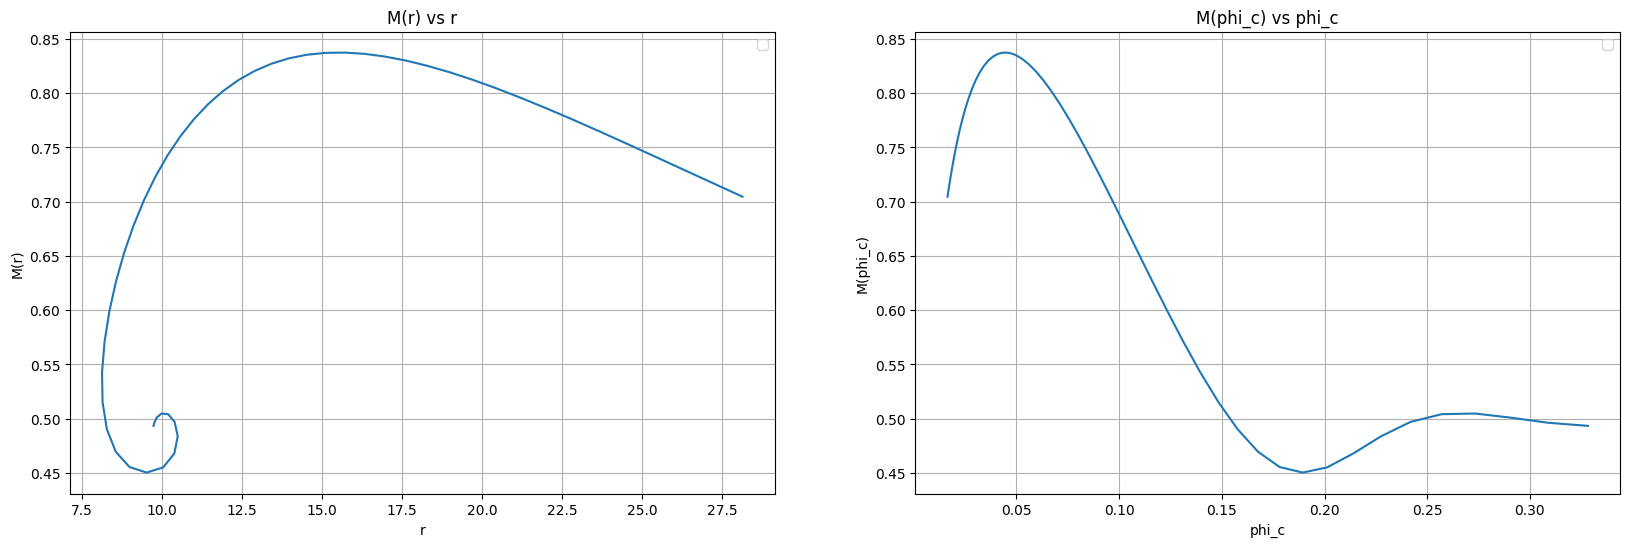

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

axs[0].plot(R_BS, M_BS)
axs[1].plot(phi0, M_BS)
   
axs[0].set_title("M(r) vs r")
axs[0].set_xlabel("r")
axs[0].set_ylabel("M(r)")
axs[0].legend()
axs[0].grid(True)

axs[1].set_title("M(phi_c) vs phi_c")
axs[1].set_xlabel("phi_c")
axs[1].set_ylabel("M(phi_c)")
axs[1].legend()
axs[1].grid(True)

# plt.tight_layout()

plt.show()

In [12]:
'''

# Solve many NS
p0 = scalep*np.exp(np.linspace(np.log(8e-3), np.log(5.0), 50))
N_NS = len(p0)

R_NS = np.zeros(N_NS)
M_NS = np.zeros(N_NS)
B_NS = np.zeros(N_NS)
a0_NS = np.zeros(N_NS)
for i in range(N_NS):
    print(cursor_up+'i/N = ', str(i+1)+'/'+str(N_NS), end = '\r')
    sol = NS(p0[i])
    R_NS[i] = sol[1][0]
    M_NS[i] = sol[1][1]
    B_NS[i] = sol[1][2]
    a0_NS[i] = sol[1][3]

# Save the data
np.savetxt('NS.dat', np.array([R_NS, M_NS, B_NS, p0, a0_BS]).T)


'''











'''

# Solve many BNS
phi0 = scalephi*np.exp(np.linspace(np.log(0.1), np.log(2.0), 50))
p0 = scalep*np.exp(np.linspace(np.log(8e-3), np.log(5.0), 50))
phi0 = np.insert(phi0, 0, 0)
p0 = np.insert(p0, 0, 0)

N_NS = len(p0)
N_BS = len(phi0)

p0_BNS = np.reshape(np.kron(p0, np.ones(N_BS)), (N_NS, N_BS))
phi0_BNS = np.reshape(np.kron(phi0, np.ones(N_NS)), (N_BS, N_NS)).T

R_NBS = np.zeros((N_NS, N_BS))
M_NBS = np.zeros((N_NS, N_BS))
B_NBS = np.zeros((N_NS, N_BS))
R_BNS = np.zeros((N_NS, N_BS))
B_BNS = np.zeros((N_NS, N_BS))
M_BNS = np.zeros((N_NS, N_BS))
omega_BNS = np.zeros((N_NS, N_BS))
a0_BNS = np.zeros((N_NS, N_BS))
for i in range(N_NS):
    for j in range(N_BS):
        print('i/N = ', str(i*N_BS+j+1)+'/'+str(N_NS*N_BS)+'\t')
        try:
            sol = BNS(p0[i], phi0[j])
            R_NBS[i, j] = sol[1][0]
            M_NBS[i, j] = sol[1][1]
            B_NBS[i, j] = sol[1][2]
            R_BNS[i, j] = sol[1][3]
            M_BNS[i, j] = sol[1][4]
            B_BNS[i, j] = sol[1][5]
            omega_BNS[i, j] = sol[1][6]
            a0_BNS[i, j] = sol[1][7]
        except:
            print('Not achieved BNS')
            continue

# Save the data
np.savetxt('BNS.dat', np.array([R_NBS.ravel(), M_NBS.ravel(), B_NBS.ravel(), R_BNS.ravel(), M_BNS.ravel(), B_BNS.ravel(), p0_BNS.ravel(), phi0_BNS.ravel(), omega_BNS.ravel(), a0_BNS.ravel()]).T)
'''

"\n\n# Solve many BNS\nphi0 = scalephi*np.exp(np.linspace(np.log(0.1), np.log(2.0), 50))\np0 = scalep*np.exp(np.linspace(np.log(8e-3), np.log(5.0), 50))\nphi0 = np.insert(phi0, 0, 0)\np0 = np.insert(p0, 0, 0)\n\nN_NS = len(p0)\nN_BS = len(phi0)\n\np0_BNS = np.reshape(np.kron(p0, np.ones(N_BS)), (N_NS, N_BS))\nphi0_BNS = np.reshape(np.kron(phi0, np.ones(N_NS)), (N_BS, N_NS)).T\n\nR_NBS = np.zeros((N_NS, N_BS))\nM_NBS = np.zeros((N_NS, N_BS))\nB_NBS = np.zeros((N_NS, N_BS))\nR_BNS = np.zeros((N_NS, N_BS))\nB_BNS = np.zeros((N_NS, N_BS))\nM_BNS = np.zeros((N_NS, N_BS))\nomega_BNS = np.zeros((N_NS, N_BS))\na0_BNS = np.zeros((N_NS, N_BS))\nfor i in range(N_NS):\n    for j in range(N_BS):\n        print('i/N = ', str(i*N_BS+j+1)+'/'+str(N_NS*N_BS)+'\t')\n        try:\n            sol = BNS(p0[i], phi0[j])\n            R_NBS[i, j] = sol[1][0]\n            M_NBS[i, j] = sol[1][1]\n            B_NBS[i, j] = sol[1][2]\n            R_BNS[i, j] = sol[1][3]\n            M_BNS[i, j] = sol[1][4]\n   